## Taking only in imporatant features as selected from the previous file 
## Main purpose is to implement pipleline

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix,classification_report
from imblearn.metrics import sensitivity_specificity_support
from imblearn.metrics import sensitivity_score ,specificity_score
from sklearn.metrics import recall_score , accuracy_score ,precision_score,f1_score,roc_auc_score

In [2]:
data=pd.read_csv('hotel_bookings.csv',parse_dates=['reservation_status_date'])

In [3]:
## Country , Company ,Ageny ,children has null values
## Company has more then 90% null values so Company can be removed easily let us remove and check

data.drop('company',axis=1,inplace=True)

## after removing Company still children country and Ageny is having null values we will check them later

In [4]:
data['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [5]:
### Data is imbalanced

In [6]:
##  0 is max count so let us fill null value of children with 0
data.children.fillna(0,inplace=True)

### Let us combine Adults, Children and Babies to one family


In [7]:
def family(df):
    if((df.adults>0) & (df.children>0)):
        fam= 1
    elif((df.adults>0) & (df.babies>0)):
        fam= 1
    else:
        fam= 0
    return fam

        

In [8]:
data['family']=data.apply(family,axis=1)

In [9]:
data['family'].value_counts()

0    110281
1      9109
Name: family, dtype: int64

In [10]:

data['total_customers']=data.adults+data.children+data.babies

In [11]:
data.drop(['adults','children','babies'], axis=1, inplace=True)

In [12]:

data.country.fillna('PRT', inplace=True)

In [13]:
## we can convert previous_cancellations as yes or no
data['previous_cancellations']=np.where(data['previous_cancellations']>0,'Yes','No')

In [14]:
data['previous_cancellations'].value_counts()

No     112906
Yes      6484
Name: previous_cancellations, dtype: int64

In [15]:
data.drop('reservation_status', axis=1 , inplace=True)

In [16]:
data.drop('arrival_date_week_number', axis=1 , inplace=True)

In [17]:
data.drop('reservation_status_date',axis=1, inplace=True)

In [18]:
data.drop('agent', axis=1 , inplace=True)

### Now our data set is cleaned with 0 null values

### arrival_date_day_of_month  and  stays_in_weekend_nights  is very less correlated to is_cancelled so we can remove and try once

In [19]:
data.drop(['arrival_date_day_of_month', 'stays_in_weekend_nights'],axis=1, inplace=True)

### Setting the list of numeric and categorial values saperatly

In [20]:
df=data.copy()

In [21]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [22]:
months={'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,
        'August':8,'September':9,'October':10,'November':11,'December':12}
df['arrival_date_month'].replace(months,inplace=True)

In [23]:
df['arrival_date_month'].dtypes

dtype('int64')

In [24]:
category_col=df.select_dtypes(include=['object']).columns
numeric_col=df.select_dtypes(include=['number']).columns

### For features with greater than 5 option we will use label encoding and for features less than 5 we will use on hot encoding and for arrival_date_month we will do manually as using label encoder it migth set diff labels

In [25]:
cat_ser=pd.Series(index=category_col)
for i in category_col:
    cat_ser[i]=df[i].nunique()

D:\Installation\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [26]:
cat_ser

hotel                       2.0
meal                        5.0
country                   177.0
market_segment              8.0
distribution_channel        5.0
previous_cancellations      2.0
reserved_room_type         10.0
assigned_room_type         12.0
deposit_type                3.0
customer_type               4.0
dtype: float64

In [27]:
lab_var=[]
for i in df:
    if (df[i].dtype=='O' and (df[i].nunique()==2 or df[i].nunique()>5 )):
        lab_var.append(i)
        

In [28]:
lab_var

['hotel',
 'country',
 'market_segment',
 'previous_cancellations',
 'reserved_room_type',
 'assigned_room_type']

In [29]:
lab= LabelEncoder()
col_count=0
for i in df:
    if (df[i].dtype=='O' and (df[i].nunique()==2 or df[i].nunique()>5 )):
        if df[i].isnull().any()==False:
            lab.fit(df[i])
            df[i]=lab.transform(df[i])
            print(i)
            col_count+=1
            
print("total_columns updated",col_count)

hotel
country
market_segment
previous_cancellations
reserved_room_type
assigned_room_type
total_columns updated 6


In [36]:
df=pd.get_dummies(df)

In [37]:
df.dtypes.value_counts()

uint8      17
int64      12
int32       6
float64     2
dtype: int64

In [42]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'stays_in_week_nights', 'country',
       'market_segment', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'family',
       'total_customers', 'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC',
       'meal_Undefined', 'distribution_channel_Corporate',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'distribution_channel_Undefined',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'customer_type_Contract',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party'],
      dtype='object')

### Saperating the data set in test and train

In [38]:
X=df.drop('is_canceled',axis=1)
y=df['is_canceled']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33, random_state=42)
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((79991, 36), (39399, 36), (79991,), (39399,))

In [40]:
scaler=StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)


In [43]:
X_train=pd.DataFrame(X_train,columns=['hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'stays_in_week_nights', 'country',
       'market_segment', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'family',
       'total_customers', 'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC',
       'meal_Undefined', 'distribution_channel_Corporate',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'distribution_channel_Undefined',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'customer_type_Contract',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party'])

In [44]:
X_test=pd.DataFrame(X_test,columns=['hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'stays_in_week_nights', 'country',
       'market_segment', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'family',
       'total_customers', 'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC',
       'meal_Undefined', 'distribution_channel_Corporate',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'distribution_channel_Undefined',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'customer_type_Contract',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party'])

In [71]:
pca=PCA(n_components=17)
new_train=pca.fit_transform(X_train.values)

In [73]:
new_test=pca.fit_transform(X_test.values)

<BarContainer object of 17 artists>

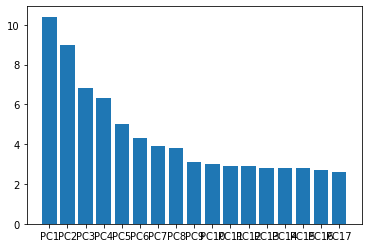

In [72]:
per_val=np.round(pca.explained_variance_ratio_*100,decimals=1)
label=['PC'+str(x) for x in range(1,len(per_val)+1)]
plt.bar(x=range(1,len(per_val)+1), height=per_val,tick_label=label)

In [86]:
new_train.shape

(79991, 17)

In [58]:
X_train.shape

(79991, 36)

In [59]:
pca_df=pd.DataFrame(new_train,index=X_train.index,columns=label)

In [66]:
y_df=pd.DataFrame(data=y_train.values,columns=['is_canceled'])

In [68]:
finalDf = pd.concat([pca_df, y_df], axis = 1)
finalDf.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,is_canceled
0,-2.339554,-1.282816,3.084072,-0.080251,0.862126,-1.138603,0.539636,0.127669,0.085943,0.053067,-0.167295,0.172178,0.349553,1
1,-3.301419,-1.647378,2.883447,1.055919,0.356516,-0.456140,-0.120168,-0.172572,0.359509,-0.180810,0.447495,-0.087356,-0.182983,1
2,-0.523996,3.521463,0.698004,-1.389864,0.694509,-0.429164,-0.526771,-0.573967,0.335753,0.701383,-0.247031,-0.274538,0.280651,0
3,0.868212,-1.858777,-0.721096,-2.848563,1.913070,0.420114,-0.518962,1.075817,-0.072563,0.573107,-0.697807,-0.170915,0.066610,0
4,0.133850,-0.753325,0.258483,-2.082405,-0.464836,-0.719573,0.591867,-0.603534,-0.045829,-0.154773,-0.052594,0.169799,0.318846,0


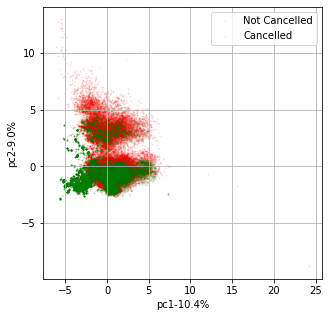

In [87]:
plt.figure(figsize = (5,5))
plt.xlabel('pc1-{0}%'.format(per_val[0]))
plt.ylabel('pc2-{0}%'.format(per_val[1]))
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['is_canceled'] == target
    plt.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 1, alpha=0.1)
plt.legend(['Not Cancelled', 'Cancelled'])
plt.grid()

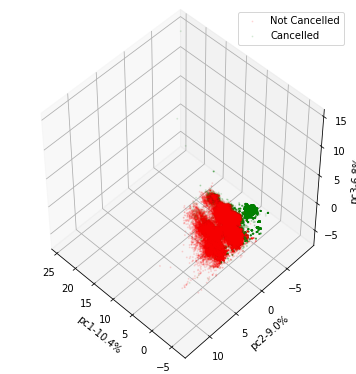

In [85]:
fig=plt.figure(figsize = (5,5))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.set_xlabel('pc1-{0}%'.format(per_val[0]))
ax.set_ylabel('pc2-{0}%'.format(per_val[1]))
ax.set_zlabel('pc3-{0}%'.format(per_val[2]))
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['is_canceled'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2'],
                finalDf.loc[indicesToKeep, 'PC3']
               , c = color
               , s = 1, alpha=0.1)
ax.legend(['Not Cancelled', 'Cancelled'])
ax.grid()

model score: 0.763
Validation Results
Recall score  0.4598156367360874
F1 score 0.5904945633111188
roc auc score 0.7010437963917974
Precision Score 0.8249418106088447
Accuracy score :  0.7629381456382142


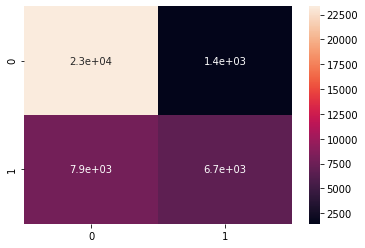

In [76]:
model=RandomForestClassifier(n_estimators=58,max_depth=28,max_features=10,min_samples_split=4,min_samples_leaf=1,criterion='gini')
model.fit(new_train,y_train)

print("model score: %.3f" % model.score(new_test, y_test))
algo_predict=model.predict(new_test)
cm_algo = confusion_matrix(y_test, algo_predict)
algo_acc = accuracy_score(y_test, algo_predict)
print('Validation Results')
print("Recall score ",recall_score(y_test, algo_predict))
print("F1 score",f1_score(y_test, algo_predict))
print("roc auc score",roc_auc_score(y_test, algo_predict))
print("Precision Score",precision_score(y_test, algo_predict))
print("Accuracy score : ",algo_acc)
sns.heatmap(cm_algo,annot=True)
    

In [77]:
model.feature_importances_

array([0.21251382, 0.11053423, 0.13792875, 0.03938355, 0.0495861 ,
       0.03761058, 0.03541063, 0.03853451, 0.03956108, 0.0324571 ,
       0.0469799 , 0.03115894, 0.04271506, 0.02868699, 0.02710592,
       0.0439313 , 0.04590154])